# Autoencoder Training Notebook
In this Jupyter notebook, you'll process the data you collected from your freezer and use it to train an autoencoder ML model to detect anomalies in the operation of your freezer. Going through this notebook should take about 30 minutes. We'll use Python and a few ML-specific libraries. You won't have to write any code, just follow the steps and run the code blocks. If you're not familiar with Jupyter notebooks, [here](https://www.dataquest.io/blog/jupyter-notebook-tutorial/) is a useful tutorial for getting started.

## Prepare your environment
First, let's load the libraries you'll need to build and train you ML model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Download your data
First, download your temperature data from Adafruit.io. Adafruit has a great guide on how to do this [here](https://learn.adafruit.com/adafruit-io-basics-feeds/downloading-feed-data). Make sure to download the data as a .CSV file and **move into the same folder as this notebook.**

> If you're using Google Colab to train your model you'll need to upload the data to your session before you can use it. To upload your data click the upload button in the left navigation and select the file you downloaded from Adafruit.io.

![](../media/colab_upload.png)

In [2]:
# Path to the dataset from Adafruit.io
# Change <PATH-TO-DATASET> to the file name of the Adafruit.io data you downloaded.
# If you're using colab your path will will './<ADAFRUIT_FILE_NAME>'
dataset_path = '<PATH-TO-DATASET>'

# Load the dataset using pandas
df = pd.read_csv(dataset_path, usecols=[1])

df

,-19.5625
0,-19.6250
1,-19.6250
2,-19.6875
3,-19.6875
4,-19.7500
...,...
228511,-18.2500
228512,-18.2500
228513,-18.2500
228514,-18.1875


## Processing your data
Next, restructure the dataset so that each row represents the time period you want to look at. An hour seems to be sufficient to account for any typical differences in the freezer temperature. 
    
>Feel free to explore how the ML model changes depending on the dataset time period

In [3]:
# The sample rate should match the code on your temperature monitor

def hours_to_seconds(hours):
    return hours * 3600

sample_rate = 0.2   # Hz (samples per second)
sample_time = 1     # Hours
datapoints_per_row = sample_rate * hours_to_seconds(sample_time)
start_time = 0

x_train = pd.DataFrame()
arr = []
for i, temp in df.iterrows():
    if i % datapoints_per_row == 0 and i != start_time:
        sample = pd.DataFrame(data=arr).T
        x_train = x_train.append(sample, ignore_index=True)
        arr = []
    arr.append(df.values[i])
raw_data = x_train.values

When training a machine learning model, it's critical to test that it works before implementing it for a real-world scenario. To do that, we split our dataset to reserve some data for testing the model after training it, which is done in the following code block. Later, we'll also use a sub-set of our training data for validation to make sure our trained model is accurate.

In [4]:
train_data, test_data = train_test_split(
    raw_data, test_size=0.2
)

In [5]:
# You can use this data later to verify that your microconroller code is working correctly
export_data = np.array(test_data)
np.savetxt('arduino_test.csv', export_data, delimiter=',')

Neural networks, which are one way to design ML models, tend to work best when the values of the data are comparable, or on a similar scale. This means that it's good practice to normalize the data. For this project, we'll normalize the data to values between 0 and 1.

In [6]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Next, let's graph a typical hour of temperature data. Try changing the index value of "train_data" to see how different parts of the dataset look.

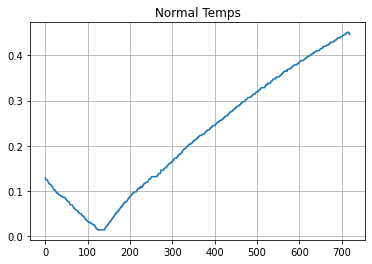

In [7]:
plt.grid()
plt.plot(np.arange(720), train_data[0])
plt.title("Normal Temps")
plt.show()

## Training your model
In this section you'll define the model architecture and train the model. Then you'll evaulate  the model  performance. 

We won't go into details of how TensorFlow works here, but you can explore how the model behaves by changing some of the key parameters, such as the number and size of layers. For more information about TensorFlow and Autoencoder model design, check out the resources provided in the project ReadMe.

In [8]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(720, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [9]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

In [10]:
history = autoencoder.fit(train_data, train_data, 
          epochs=60, 
          batch_size=16,
          validation_split = 0.1,
          shuffle=True)

Epoch 1/60
15/15 [==============================] - 0s 11ms/step - loss: 0.2549 - val_loss: 0.2136
Epoch 2/60
15/15 [==============================] - 0s 3ms/step - loss: 0.1668 - val_loss: 0.1339
Epoch 3/60
15/15 [==============================] - 0s 4ms/step - loss: 0.1279 - val_loss: 0.1186
Epoch 4/60
15/15 [==============================] - 0s 4ms/step - loss: 0.1187 - val_loss: 0.1155
Epoch 5/60
15/15 [==============================] - 0s 3ms/step - loss: 0.1150 - val_loss: 0.1064
Epoch 6/60
15/15 [==============================] - 0s 2ms/step - loss: 0.1052 - val_loss: 0.0948
Epoch 7/60
15/15 [==============================] - 0s 3ms/step - loss: 0.0900 - val_loss: 0.0799
Epoch 8/60
15/15 [==============================] - 0s 2ms/step - loss: 0.0742 - val_loss: 0.0612
Epoch 9/60
15/15 [==============================] - 0s 3ms/step - loss: 0.0601 - val_loss: 0.0504
Epoch 10/60
15/15 [==============================] - 0s 3ms/step - loss: 0.0537 - val_loss: 0.0478
Epoch 11/60
15/15 

Now that you've trained the model, look at the loss and validation loss of final epoch to evaluate the model performance. Both of these should be pretty small, less than 0.05, and close together in value. We an also see in the next graph how the model progressed in training.

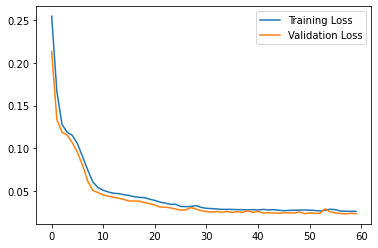

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You can also observe how the autoencoder works by graphing the original data and overlaying the reconstructed data. The difference between each data point is the error value that we check against to see how close the data is to normal operation. The first graph shows the first training data point, and the second will show the first testing data point. Rembmer that the model hasn't been trained on any of the test data, so this is the first real test of the model's behavior on new data.

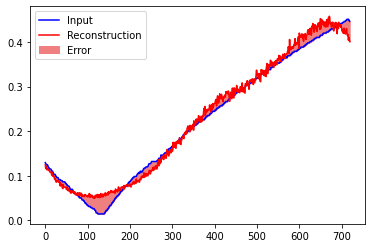

In [12]:
encoded_imgs = autoencoder.encoder(train_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(train_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(720), decoded_imgs[0], train_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

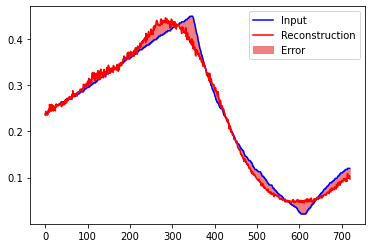

In [13]:
encoded_imgs = autoencoder.encoder(test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(720), decoded_imgs[0], test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Next we'll calculate a threshold value that is one standard deviation higher than the mean of our training data loss. We'll use this threshold to determine whether an hour of data is typical or anomalous operation.

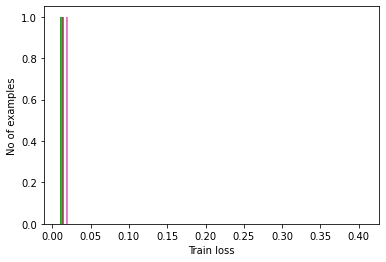

In [14]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [15]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.08214326


## Testing your model
Before finalizing our model, we need to check its performance on new data. First, we'll print the metrics from the training set and then compare the metrics from the test set. If the metrics are similar, our model has generalized well enough to work. 
    
If the metrics are different, then our model is likely overfitting, or performing well on the training data but not well in general. If you find this is the case, training on more data can help.

In [16]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  # Accuracy measures the total number of correct predictions and divides it by the total number of predictions made.
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  # Recall measure the total true positives divided by false negative and true positives.
  # Note that in this case a positive result is typical operation.
  print("Recall = {}".format(recall_score(labels, preds)))

In [17]:
preds = predict(autoencoder, train_data, threshold)
labels = np.ones(preds.shape[0])
print_stats(preds, labels)

preds = predict(autoencoder, test_data, threshold)
labels = np.ones(preds.shape[0])
print_stats(preds, labels)

Accuracy = 0.9644268774703557
Precision = 1.0
Recall = 0.9644268774703557
Accuracy = 0.90625
Precision = 1.0
Recall = 0.90625


## Exporting your model
Finally, you're ready to deploy your model to your IoT device! To do this, copy the constants you used in training into your Arduino sketch and export your model.

In [18]:
print('const int input_size = {};'.format(train_data.shape[1]))
print('const float threshold = {};'.format(threshold))
print('const float min_val = {};'.format(min_val))
print('const float max_val = {};'.format(max_val))

const int input_size = 720;
const float threshold = 0.08214326202869415;
const float min_val = -21.75;
const float max_val = 4.3125;


In [19]:
# Convert the model to a TF Lite flat buffer.
converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
# Model optimization is done to conserve memory on the microcontroller. Note that optimization will slightly reduce the model's performance. For most use-cases, this is an acceptable trade-off. If you find the model performing noticeably worse once installed and need better results, skip optimization and compare model performance.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\adazulay\AppData\Local\Temp\tmp5eddcds7\assets


In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd

# Use xxd to export a C array of your model
!xxd -i model.tflite model_data.h

Once the conversion is complete you can download the model_data.h file and save into the *AIFreezerMonitor* folder.